In [1]:
from astropy.io import fits
import clevar
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
from clevar.match_metrics.distances import ClCatalogFuncs as d_cf
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf
import clevar.match_metrics.scaling as scaling

import pandas as pd
from astropy.table import Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

In [2]:
hdul_ame = fits.open("richness_mcut_SNR 12_ame.fits")
hdul_rfae = fits.open("richness_mcut_SNR_12_Rfae.fits")

lnRmin  = 3
lnRmax  = 5.5
zmin    = 0.0
zmax    = 0.664

table_ame = hdul_ame[1].data
table_rfae = hdul_rfae[1].data

print(table_ame.size)
print(table_rfae.size)

print(table_rfae.columns)
print(table_rfae["R_fae"])
print(table_rfae["R_ame"])

table_ame = table_ame[(table_ame["R_ame"] >=np.exp(lnRmin)) & (table_ame["R_ame"] <= np.exp(lnRmax)) & (table_ame["z"] >=zmin)
                      & (table_ame["z"] <=zmax)]

23751
23751
ColDefs(
    name = 'ID'; format = 'I'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'z'; format = 'D'
    name = 'z_err'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'SNR_ORIG'; format = 'D'
    name = 'richness'; format = 'D'
    name = 'radius'; format = 'D'
    name = 'rank'; format = 'J'
    name = 'Rc'; format = 'D'
    name = 'R_fae'; format = 'D'
    name = 'R_fae_err'; format = 'D'
    name = 'R_ame'; format = 'E'
    name = 'R_ame_err'; format = 'D'
)
[515.84112335 437.09370213 321.93766592 ...  87.81300269 103.80587269
 109.58842567]
[273.   231.   170.   ...  45.46  50.4   55.6 ]


In [3]:
area = 4109.3
cosmo = Nc.HICosmoDEXcdm()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegax", 0.6911)
cosmo.param_set_by_name("Omegac", 0.2603)
cosmo.param_set_by_name("w", -1.0)

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", False)




prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.02745)
prim.param_set_by_name("n_SA", 0.9667)
prim.set_property("ln10e10ASA_fit", True)


reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()

mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, None)
cad.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)

#σ_8 = 0.8159

In [4]:
#mass proxy

cluster_m = Nc.ClusterMassLnrichExt(lnRichness_min = np.log(table_ame['R_ame'].min()) ,lnRichness_max =  np.log(table_ame['R_ame'].max()))
cluster_m.param_set_by_name("mu",4.164)
cluster_m.param_set_by_name("muM1", 0.5088)
cluster_m.param_set_by_name("muZ1", -4.494)
cluster_m.param_set_by_name("muM2", 0.1309)
cluster_m.param_set_by_name("muZ2", -9.685)
cluster_m.param_set_by_name("muMZ", -0.7108)

cluster_m.param_set_by_name("sigma0", 3.69)
cluster_m.param_set_by_name("sigmaM1", 1.048)
cluster_m.param_set_by_name("sigmaZ1", -1.562)
cluster_m.param_set_by_name("sigmaM2", 0.122)
cluster_m.param_set_by_name("sigmaZ2", -8.488)
cluster_m.param_set_by_name("sigmaMZ", 0.4834)

cluster_m.param_set_by_name("A0", 0.2235)
cluster_m.param_set_by_name("cut", 7.436)
cluster_m.param_set_by_name("cutM1", -0.5809)
cluster_m.param_set_by_name("cutZ1", 0.398)


cluster_m_ascaso = Nc.ClusterMassAscaso(lnRichness_min = np.log(table_ame['R_ame'].min()) ,lnRichness_max = np.log(table_ame['R_ame'].max()))
cluster_m_ascaso.param_set_by_name("mup0",4.368)
cluster_m_ascaso.param_set_by_name("mup1", 0.2566)
cluster_m_ascaso.param_set_by_name("mup2", 0.4474 )
cluster_m_ascaso.param_set_by_name("sigmap0",  0.3034 )
cluster_m_ascaso.param_set_by_name("sigmap1", -0.04202)
cluster_m_ascaso.param_set_by_name("sigmap2", 0.005575)



#photo-z
cluster_z = Nc.ClusterPhotozGauss (pz_min = zmin , pz_max = zmax)
#cluster_z = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)

print("\n")
print(cluster_m.p(cosmo , 34.45, 0.1 , [np.log(35.46546)] , [1.175]))
print(cluster_m.intp(cosmo , 34 , 0.1))
print(cluster_m.intp_bin(cosmo , 34.45 , 0.1 , [1] , [10] , [2.90969]))
print("\n")
'''
print(cluster_z.p(cosmo , 32 , 0.66 , [0.657513] , [0,0.007513]))
print(cluster_z.intp(cosmo , 32 , 0.9))
print(cluster_z.intp_bin(cosmo , 32 , 0.9, [0.8] , [1.0] , [0,0.0513]))
print("\n")

'''



1.023834274626499e-09
0.9979854616376171
1.0




'\nprint(cluster_z.p(cosmo , 32 , 0.66 , [0.657513] , [0,0.007513]))\nprint(cluster_z.intp(cosmo , 32 , 0.9))\nprint(cluster_z.intp_bin(cosmo , 32 , 0.9, [0.8] , [1.0] , [0,0.0513]))\nprint("\n")\n\n'

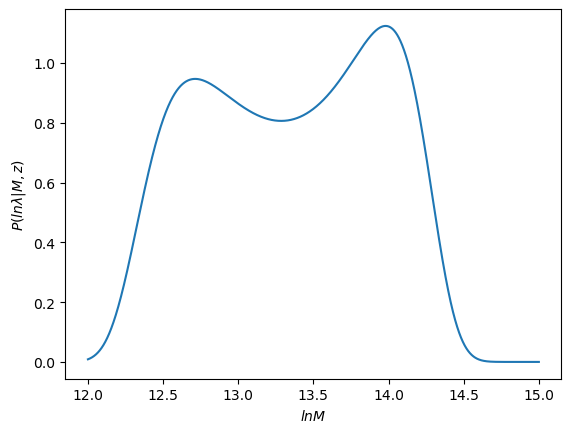

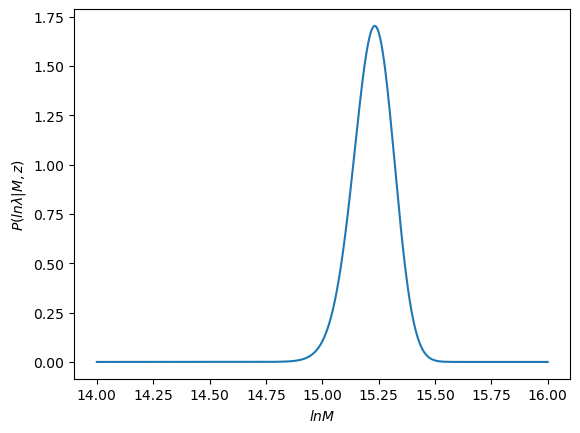

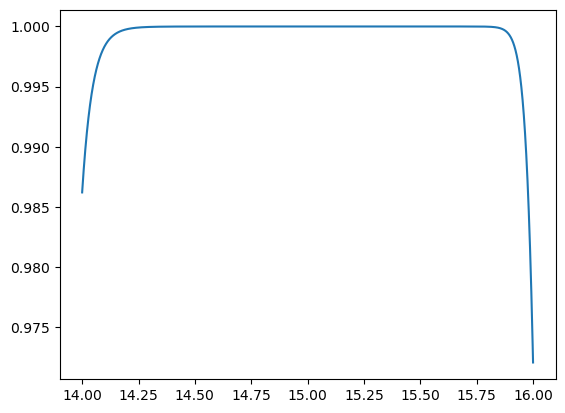

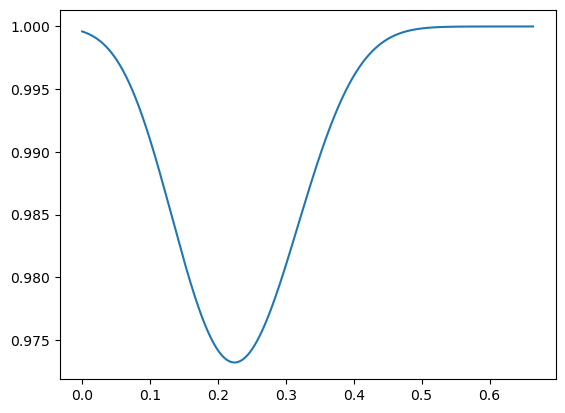

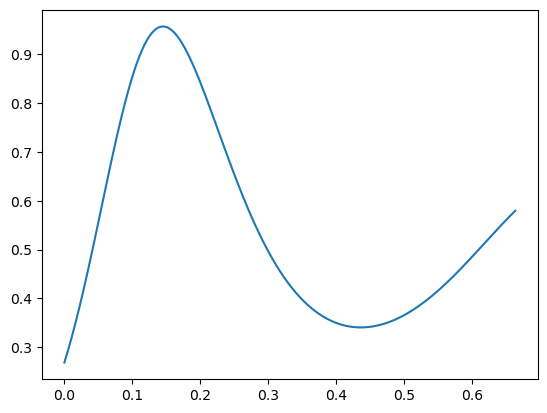

In [5]:
masses  = np.linspace(np.log(10) *12.0, np.log(10) * 15.0,10000)
masses_10  = np.linspace(12.0 ,15,10000)
z  = np.linspace(0 ,0.664,10000)
relation = []
relation_z = []
cdf_m = []
cdf_z = []

for i in range(len(masses)):
    relation.append(cluster_m.p(cosmo , masses[i], 0.1 , [np.log(35.46546)] , None))
    relation_z.append(cluster_m.p(cosmo , 30, z[i] , [np.log(35.46546)] , None))
    cdf_m.append(cluster_m.intp_bin(cosmo , masses[i], 0.2,  [0.0], [5.82], None))
    cdf_z.append(cluster_m.intp_bin(cosmo , 34.53,z[i],[0.6], [5.82], None))
plt.plot(masses_10 , relation)
plt.ylabel(r'$P(ln\lambda|M,z)$')
plt.xlabel(r'$lnM$')
plt.savefig("cobra_comendo_elefante.jpg")
plt.show()

masses  = np.linspace(np.log(10) *14.0, np.log(10) * 16  ,10000)
masses_10  = np.linspace(14.0 ,16    ,10000)
relation = []

for i in range(len(masses)):
    relation.append(cluster_m.p(cosmo , masses[i], 0.1 , [np.log(338.48)] , [1.942005]))
plt.plot(masses_10 , relation)
plt.ylabel(r'$P(ln\lambda|M,z)$')
plt.xlabel(r'$lnM$')
plt.show()

plt.plot(masses_10 , cdf_m)
plt.show()

plt.plot(z , cdf_z)
plt.show()

plt.plot(z , relation_z)
plt.show()

In [6]:
mset = Ncm.MSet.new_array([cosmo, cluster_m, cluster_z])
ncdata = Nc.DataClusterNCount.new(cad, "NcClusterPhotozGauss", "NcClusterMassLnrichExt")
#ncdata = Nc.DataClusterNCount.new(cad, "NcClusterPhotozGauss", "NcClusterMassAscaso")
ncdata.set_init(True)



richness = np.array(table_ame['R_ame'])
redshift = np.array(table_ame['z'])
redshift_err = np.array(table_ame['z_err'])

z_obs_params = Ncm.Matrix.new(len(redshift_err), 2)
for i in range(len(redshift_err)):
    for j in range(0, 2):
        if j == 0:
            z_obs_params.set(i, j, 0)
        if j == 1:
            z_obs_params.set(i, j,  redshift_err[i])
print(richness) 

ncdata.set_lnM_obs(Ncm.Matrix.new_array(richness, 1))
ncdata.set_z_obs(Ncm.Matrix.new_array(redshift, 1))
ncdata.set_z_obs_params(z_obs_params)
ncdata.true_data(False)

dset = Ncm.Dataset.new_array([ncdata])
likelihood = Ncm.Likelihood.new(dset)

experiment = Ncm.ObjDictStr()
experiment.set("likelihood", likelihood)
experiment.set("model-set", mset)
ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
ser.dict_str_to_yaml_file(experiment, "unbinned.yaml")

ca =[]
lnM_obs = ncdata.get_lnM_obs()
z_obs = ncdata.get_z_obs()
z_obs_params = ncdata.get_z_obs_params()

mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)


hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area(area * (np.pi / 180) ** 2)

hmf.prepare(cosmo)
cad = Nc.ClusterAbundance.new(hmf, None)
hmf.prepare(cosmo)
cad.prepare(cosmo , cluster_z , cluster_m)
cad.set_area(area * (np.pi / 180) ** 2)
print(cad.n(cosmo , cluster_z , cluster_m))

#Fit
fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", likelihood, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )#
fit.log_info()
#fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
#fit.log_info()



[231.   170.   156.   ...  45.46  50.4   55.6 ]
10266841.891333165
#----------------------------------------------------------------------------------
# Data used:
#   - Cluster abundance unbinned
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.74               [FIXED]
#   -     Omegac[01]:  0.2603              [FREE]
#   -     Omegax[02]:  0.6911              [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0486              [FIXED]
#   -          w[07]: -1                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra

In [7]:
clusters_dt = Table([table_ame['R_ame'], table_ame['z'] , table_ame['z_err']], names=('richness' , 'z' , 'z_err'))

z = clusters_dt["z"]  # redshift
lnR = np.log(clusters_dt["richness"])  # ln(richness)

#bins:

z_bins = 1
d = (max(z) - min (z))/z_bins

r_bins = 100
d_r = (max(lnR) - min (lnR))/r_bins


print(f'Number of z bins: {z_bins}.\nNumber of lnR bins: {r_bins}.\nTotal bins: {z_bins * r_bins}.')

# redshift bins
z_0 = 0.0
z_1 = d
halos_bin_z =[]

for i in range(z_bins):
    cut_z = np.logical_and (clusters_dt['z'] > z_0, clusters_dt['z'] < z_1)
    halos_bin_z.append(clusters_dt[cut_z])
    z_0 = z_0 + d
    z_1 = z_1 + d
# mass bins
label = []
halos_bin_rz =[]
for i in range(z_bins):
    
    lnR_0 = min(lnR)
    lnR_1 = min(lnR) + d_r
    for j in range(r_bins):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["richness"]) > lnR_0, np.log(halos_bin_z[i]["richness"]) < lnR_1)
        halos_bin_rz.append(halos_bin_z[i][cut])
        
        lnR_0 = lnR_0 + d_r
        lnR_1 = lnR_1 + d_r
        
print(f'Total bins in halos_bin_rz: {len(halos_bin_rz)}')

z_binned, z_err_binned, lnR_binned =[], [], [] 

for i in range(len(halos_bin_rz)):
    
    halos = halos_bin_rz[i]
    
    z_err_binned.append(halos["z_err"])
    z_binned.append(halos["z"])
    lnR_binned.append(np.log(halos["richness"]))   

lnR_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 1], [np.mean(k) for k in z_binned if len(k) > 1]
lnR_std, z_std = [np.std(l) for l in lnR_binned if len(l) > 1], [np.mean(k) for k in z_err_binned if len(k) > 1]


halos_mean = Table([np.exp(np.array(lnR_mean)), z_mean],
           names=('richness', 'z'))

halos_std = Table([np.exp(np.array(lnR_std)), z_std],
           names=('richness', 'z'))

print(f'Total bins in halos_mean: {len(halos_mean)}')

Number of z bins: 1.
Number of lnR bins: 100.
Total bins: 100.
Total bins in halos_bin_rz: 100
Total bins in halos_mean: 98


0.00000 , 0.66400


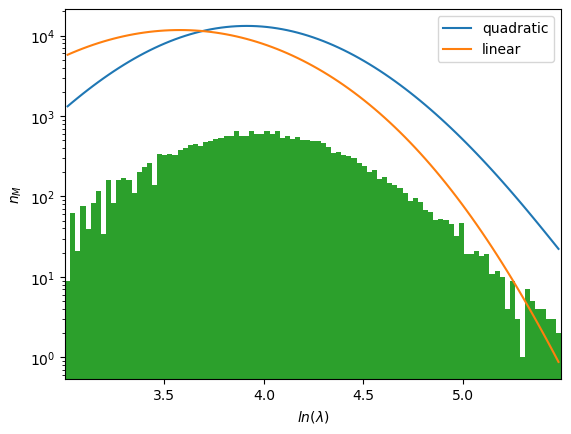

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-145.91043975904734, -22.729948029410746, -79.26719471367247, -23.626910553393422, -53.49483799422129, -27.9823781915787, -21.82807347256499, -85.53307482644955, -19.492907685329087, -41.81934601753193, -23.427045195011964, -24.67731964094885, -28.450923543028356, -45.11366035461077, -27.167078625062295, -24.79451022075359, -24.220889294110652, -49.099232291806885, -21.069635861419762, -23.61002232808341, -24.278588370590235, -26.73512524326026, -24.392925369890108, -24.177544686357535, -22.96953304720897, -23.3589689612463, -25.662512467751945, -23.186868119990088, -23.70617688411304, -22.824503782073982, -22.74908247286064, -21.594897685465437, -21.669894707569846, -18.933889455024286, -22.611732957107648, -22.367435983122245, -19.119064422917912, -20.90967350515055, -20.55356954381086, -18.78348784824195, -19.893258291113156, -17.882531772525304, -21.354574764349692, -19.858464220467294, -20.90692822330626, -18.88100547903416, -19.59725041005105, -18.665913079735283, -18.3529514950

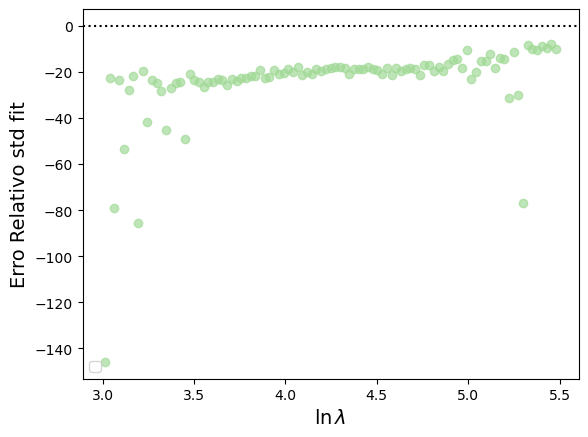

In [8]:
cluster_z_no = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)
richness = np.linspace(np.log(table_ame['R_ame'].min()), np.log(table_ame['R_ame'].max()), len(halos_mean))
richness_plot = []
n_bin = []
n_bin_no = []
for i in range(len(richness)-1):
    
    n_bin.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [richness[i]] ,[richness[i+1]],None ,[zmin] , [zmax] , [0 , z_std[i]])/np.log(10))
    n_bin_no.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m_ascaso , [richness[i]] ,[richness[i+1]],None ,[zmin] , [zmax] , [0 , z_std[i]])/np.log(10))
    
    richness_plot.append((richness[i] + richness[i+1])/2)

print("%.5f , %.5f" % (zmin , zmax))
legend = ["quadratic" , "linear"]
    
    
plt.plot(richness_plot , n_bin , label = "%s" %(legend[0]))
plt.plot(richness_plot , n_bin_no , label = "%s" %(legend[1]))

counts_rich, bins = np.histogram(np.log(table_ame['R_ame']), bins=(len(richness)-1))
plt.xlim(np.log(table_ame['R_ame'].min()) , np.log(table_ame['R_ame'].max()))
plt.legend()
plt.xlabel(r"$ln(\lambda)$")
plt.ylabel(r"$n_M$")
plt.yscale("log")
plt.hist(np.log(table_ame['R_ame']), bins=(len(richness)-1))
plt.show()


diff = []
for i in range(len(n_bin)):
    diff.append((counts_rich[i] - n_bin[i])/counts_rich[i])
    

plt.scatter(richness_plot, diff, c='#a0d995', alpha=0.6774)
plt.legend()
plt.xlabel(r'$\ln\lambda$', size=14)
plt.ylabel('Erro Relativo std fit', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')

print(diff)

## Cluster counts z distribution

In [9]:
clusters_dt = Table([table_ame['R_ame'], table_ame['z'] , table_ame['z_err']], names=('richness' , 'z' , 'z_err'))

z = clusters_dt["z"]  # redshift
lnR = np.log(clusters_dt["richness"])  # ln(richness)

#bins:

z_bins = 100
d = (max(z) - min (z))/z_bins

r_bins = 1
d_r = (max(lnR) - min (lnR))/r_bins


print(f'Number of z bins: {z_bins}.\nNumber of lnR bins: {r_bins}.\nTotal bins: {z_bins * r_bins}.')

# redshift bins
z_0 = 0.0
z_1 = d
halos_bin_z =[]

for i in range(z_bins):
    cut_z = np.logical_and (clusters_dt['z'] > z_0, clusters_dt['z'] < z_1)
    halos_bin_z.append(clusters_dt[cut_z])
    z_0 = z_0 + d
    z_1 = z_1 + d
# mass bins
label = []
halos_bin_rz =[]
for i in range(z_bins):
    
    lnR_0 = min(lnR)
    lnR_1 = min(lnR) + d_r
    for j in range(r_bins):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["richness"]) > lnR_0, np.log(halos_bin_z[i]["richness"]) < lnR_1)
        halos_bin_rz.append(halos_bin_z[i][cut])
        
        lnR_0 = lnR_0 + d_r
        lnR_1 = lnR_1 + d_r
        
print(f'Total bins in halos_bin_rz: {len(halos_bin_rz)}')

z_binned, z_err_binned, lnR_binned =[], [], [] 

for i in range(len(halos_bin_rz)):
    
    halos = halos_bin_rz[i]
    
    z_err_binned.append(halos["z_err"])
    z_binned.append(halos["z"])
    lnR_binned.append(np.log(halos["richness"]))   

lnR_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 1], [np.mean(k) for k in z_binned if len(k) > 1]
lnR_std, z_std = [np.std(l) for l in lnR_binned if len(l) > 1], [np.mean(k) for k in z_err_binned if len(k) > 1]


halos_mean = Table([np.exp(np.array(lnR_mean)), z_mean],
           names=('richness', 'z'))

halos_std = Table([np.exp(np.array(lnR_std)), z_std],
           names=('richness', 'z'))

print(f'Total bins in halos_mean: {len(halos_mean)}')

Number of z bins: 100.
Number of lnR bins: 1.
Total bins: 100.
Total bins in halos_bin_rz: 100
Total bins in halos_mean: 93


0.00000 , 0.66400


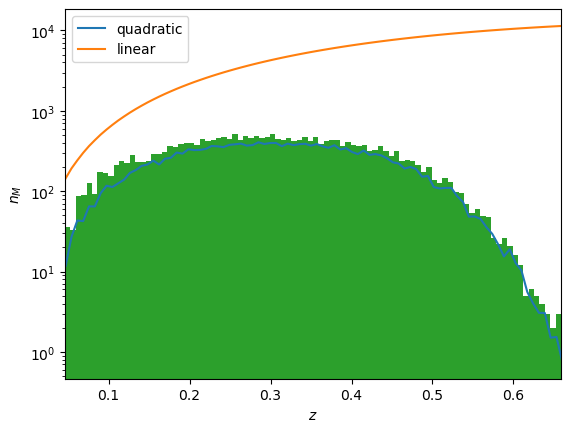

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([nan]), array([nan]), array([nan]), array([nan]), array([nan]), array([nan]), array([0.93156905]), array([0.83843578]), array([0.72120809]), array([0.79690751]), array([0.72803387]), array([0.71271958]), array([0.66538963]), array([0.50029998]), array([0.51409395]), array([0.47346856]), array([0.52680008]), array([0.42553809]), array([0.39919902]), array([0.43406052]), array([0.40124356]), array([0.37567866]), array([0.4579706]), array([0.35445413]), array([0.29979089]), array([0.31460811]), array([0.29572674]), array([0.22523157]), array([0.28906624]), array([0.30207489]), array([0.25121494]), array([0.2833426]), array([0.15623132]), array([0.26990906]), array([0.17022203]), array([0.22289912]), array([0.13991149]), array([0.22568231]), array([0.28054898]), array([0.09054837]), array([0.10821812]), array([0.13520038]), array([0.0584907]), array([0.15311846]), array([0.16650941]), array([0.11108201]), array([0.18025834]), array([0.00697784]), array([0.12069668]), array([0.098819

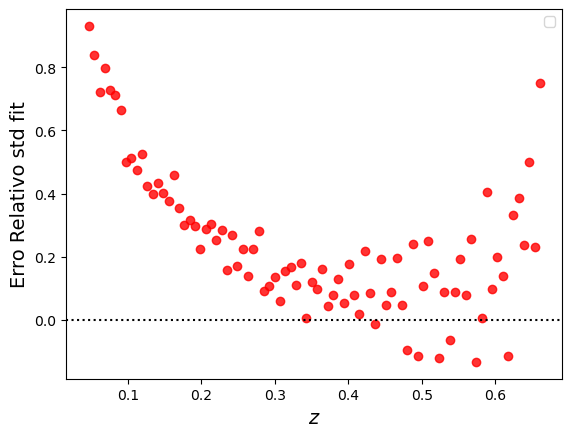

In [17]:
z = np.linspace(zmin, zmax, len(halos_mean))

cluster_z_no = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)
z_plot = []
n_bin = []
n_bin_no = []
for i in range(len(z)-1):
    n_bin.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [lnRmin] ,[lnRmax],None ,[z[i]] , [z[i+1]] , [0.0,z_std[i]])*info['data']['recovery'][i]/info2['data']['recovery'][i]/np.log(10))
    n_bin_no.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m_ascaso , [lnRmin] ,[lnRmax],None ,[z[i]] , [z[i+1]] , [0.0,z_std[i]])/np.log(10))
    z_plot.append((z[i] + z[i+1])/2)

print("%.5f , %.5f" % (zmin , zmax))
legend = ["quadratic" , "linear"]
    
    
plt.plot(z_plot , n_bin , label = "%s" %(legend[0]))
plt.plot(z_plot , n_bin_no , label = "%s" %(legend[1]))

counts_z, bins = np.histogram(table_ame['z'], bins=(len(z)-1))
plt.xlim(table_ame['z'].min() , table_ame['z'].max())
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"$n_M$")
plt.yscale("log")
plt.hist(table_ame['z'], bins=(len(z)-1))
plt.show()


diff = []
for i in range(len(n_bin)):
    diff.append((counts_z[i] - n_bin[i])/counts_z[i])
    

plt.scatter(z_plot, diff, c='r', alpha=0.8)
plt.legend()
plt.xlabel(r'$z$', size=14)
plt.ylabel('Erro Relativo std fit', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')

print(diff)

689973
23751
ColDefs(
    name = 'ID'; format = 'I'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'z'; format = 'D'
    name = 'z_err'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'SNR_ORIG'; format = 'D'
    name = 'richness'; format = 'D'
    name = 'radius'; format = 'D'
    name = 'rank'; format = 'J'
    name = 'Rc'; format = 'D'
    name = 'R_ame'; format = 'D'
    name = 'R_ame_err'; format = 'D'
)


/global/u2/l/lettieri/miniforge3/envs/numcosmo_developer/lib/python3.12/site-packages/clevar-0.15.3-py3.12.egg/clevar/catalog/tagdata.py:278: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")


Halo catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    689,973
 * multiple (self):  25,922
 * multiple (other): 25,922
 * unique (self):    22,285
 * unique (other):   22,285
 * cross:            22,271

Detection catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    23,751
 * multiple (self):  22,285
 * multiple (other): 22,285
 * unique (self):    22,285
 * unique (other):   22,285
 * cross:            22,271


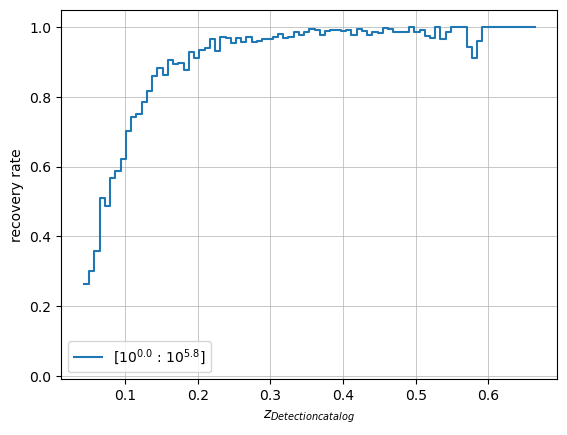

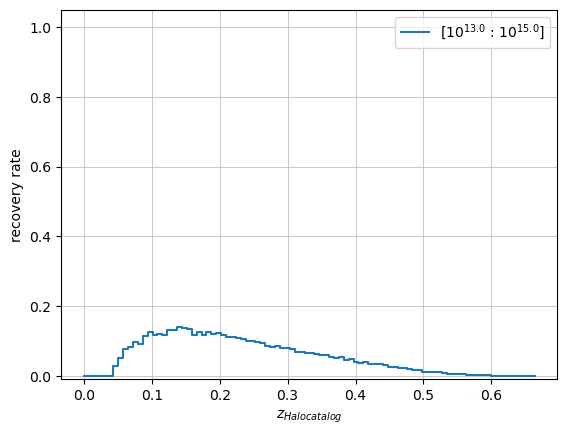

In [11]:
from clevar.match_metrics import recovery
hdul_halos = fits.open("../halos/halos.fits")
hdul_ame = fits.open("richness_mcut_SNR 12_ame.fits")

logMmin = 13
logMmax = 15

table_halos = hdul_halos[1].data
table_ame = hdul_ame[1].data
table_halos = table_halos[(table_halos['upid'] == -1)  &  (table_halos['Mvir'] >= 10**logMmin) & (table_halos['Mvir'] <= 10**logMmax)]
table_halos['Mvir'] = table_halos['Mvir']/0.6774

print(table_halos.size)
print(table_ame.size)

print(table_ame.columns)

catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_ame = clevar.ClCatalog('Detection catalog', ra=table_ame['RA'], dec=table_ame['DEC']
                             , z=table_ame['z'], mass=table_ame['R_ame']  , mass_err=table_ame['R_ame_err'] ,z_err=table_ame['z_err'] , )
mt = clevar.match.ProximityMatch()
mt.load_matches(catalog_halos, catalog_ame, out_dir='temp')

halos_match, detections_match = clevar.match.get_matched_pairs(catalog_halos, catalog_ame, 'cross')

detections_match

zbins = np.linspace(0, 0.664, 93)
mbins = np.logspace(13, 15, 2)
rbins = np.logspace(0 , 5.8, 2)

info2 = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
plt.show()
info = recovery.plot(catalog_halos, 'cross', zbins, mbins, shape='steps')